In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pyarrow as pa
import pyarrow.parquet as pq
from pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from sklearn.metrics import mean_squared_error
from math import sqrt

# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima # for determining ARIMA orders

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load dataset
df_crimes_summary = pd.read_csv('crimes_summary.csv', parse_dates=['occurred_date_time'])

In [ ]:
#this dataframe list top ten crimes which occur in the zip code 78701 under census_tract 11 which falls under council_district 9.
#Top ten crimes are : ASSAULT BY CONTACT,ASSAULT WITH INJURY,BURGLARY OF VEHICLE,CRIMINAL MISCHIEF,DISTURBANCE - OTHER,DWI,POSS OF DRUG PARAPHERNALIA,THEFT,VIOL CITY ORDINANCE - OTHER,WARRANT ARREST NON TRAFFIC

In [3]:
df_crimes_summary.head()

,incident_report_number,crime_type,ucr_code,family_violence,location_type,address,zip_code,council_district,sector,district,...,clearance_status,clearance_date,occurred_date_time,reported_date_time,month,year,hour,year_month,occurred_day,cal_month
0,20223650465,ASSAULT WITH INJURY,900,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,700 BLOCK E 7TH ST,78701,9,GE,2,...,N,2023-01-03T00:00:00.000,2022-12-31 09:24:00,2022-12-31 09:24:00,December,2022,9,2022-12,31,12
1,20223650192,DWI,2100,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,E 9TH ST / N IH 35 SVRD SB,78701,9,CH,2,...,C,2022-12-31T00:00:00.000,2022-12-31 02:39:00,2022-12-31 02:39:00,December,2022,2,2022-12,31,12
2,20223641477,ASSAULT BY CONTACT,902,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,708 E 6TH ST,78701,9,GE,2,...,N,2023-01-03T00:00:00.000,2022-12-30 23:40:00,2022-12-30 23:40:00,December,2022,23,2022-12,30,12
3,20223641378,DISTURBANCE - OTHER,3401,N,RESTAURANT,414 E 6TH ST,78701,9,GE,2,...,NaN,NaN,2022-12-30 22:28:00,2022-12-30 23:01:00,December,2022,22,2022-12,30,12
4,20223640858,ASSAULT WITH INJURY,900,N,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,400 E 8TH ST,78701,9,GE,1,...,N,2023-01-04T00:00:00.000,2022-12-30 15:55:00,2022-12-30 15:55:00,December,2022,15,2022-12,30,12


In [5]:
df_crimes_types=df_crimes_summary[['occurred_date_time','crime_type','family_violence','hour','occurred_day','cal_month','year_month','year']]

In [6]:
df_crimes_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30680 entries, 0 to 30679
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   occurred_date_time  30680 non-null  datetime64[ns]
 1   crime_type          30680 non-null  object        
 2   family_violence     30680 non-null  object        
 3   hour                30680 non-null  int64         
 4   occurred_day        30680 non-null  int64         
 5   cal_month           30680 non-null  int64         
 6   year_month          30680 non-null  object        
 7   year                30680 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 1.9+ MB


In [7]:

df_assault = df_crimes_types.loc[(df_crimes_types['crime_type'] == 'ASSAULT WITH INJURY')]

In [8]:
df_assault.shape

(4260, 8)

In [9]:
df_assault.head(5)

,occurred_date_time,crime_type,family_violence,hour,occurred_day,cal_month,year_month,year
0,2022-12-31 09:24:00,ASSAULT WITH INJURY,N,9,31,12,2022-12,2022
4,2022-12-30 15:55:00,ASSAULT WITH INJURY,N,15,30,12,2022-12,2022
7,2022-12-28 23:35:00,ASSAULT WITH INJURY,N,23,28,12,2022-12,2022
11,2022-12-27 22:39:00,ASSAULT WITH INJURY,N,22,27,12,2022-12,2022
15,2022-12-26 12:29:00,ASSAULT WITH INJURY,N,12,26,12,2022-12,2022


### Hourly level dataset preparation

In [11]:
df_assault['occurred_date'] = pd.to_datetime(df_assault['occurred_date_time'], format='%Y-%m-%d').dt.floor('H')

In [12]:
df_assault.head()

,occurred_date_time,crime_type,family_violence,hour,occurred_day,cal_month,year_month,year,occurred_date
0,2022-12-31 09:24:00,ASSAULT WITH INJURY,N,9,31,12,2022-12,2022,2022-12-31 09:00:00
4,2022-12-30 15:55:00,ASSAULT WITH INJURY,N,15,30,12,2022-12,2022,2022-12-30 15:00:00
7,2022-12-28 23:35:00,ASSAULT WITH INJURY,N,23,28,12,2022-12,2022,2022-12-28 23:00:00
11,2022-12-27 22:39:00,ASSAULT WITH INJURY,N,22,27,12,2022-12,2022,2022-12-27 22:00:00
15,2022-12-26 12:29:00,ASSAULT WITH INJURY,N,12,26,12,2022-12,2022,2022-12-26 12:00:00


In [14]:
df_assault.dtypes

occurred_date_time    datetime64[ns]
crime_type                    object
family_violence               object
hour                           int64
occurred_day                   int64
cal_month                      int64
year_month                    object
year                           int64
occurred_date         datetime64[ns]
dtype: object

In [15]:
df_assault.year.unique()

array([2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013],
      dtype=int64)

In [17]:
df_assault_21_22 = df_assault[df_assault.occurred_date.between('2021-01-01 00:00:00', '2022-12-31 23:00:00')]

In [18]:
df_assault_21_22.shape

(718, 9)

In [19]:
df_assault_21_22.head()

,occurred_date_time,crime_type,family_violence,hour,occurred_day,cal_month,year_month,year,occurred_date
0,2022-12-31 09:24:00,ASSAULT WITH INJURY,N,9,31,12,2022-12,2022,2022-12-31 09:00:00
4,2022-12-30 15:55:00,ASSAULT WITH INJURY,N,15,30,12,2022-12,2022,2022-12-30 15:00:00
7,2022-12-28 23:35:00,ASSAULT WITH INJURY,N,23,28,12,2022-12,2022,2022-12-28 23:00:00
11,2022-12-27 22:39:00,ASSAULT WITH INJURY,N,22,27,12,2022-12,2022,2022-12-27 22:00:00
15,2022-12-26 12:29:00,ASSAULT WITH INJURY,N,12,26,12,2022-12,2022,2022-12-26 12:00:00


In [20]:
df_assault_21_22_gp = df_assault_21_22.groupby(['occurred_date']).agg(
    assault_count=('crime_type', 'count'),
    
 ).reset_index()

In [21]:
df_assault_21_22_gp.sort_values(by = ['occurred_date'], ascending = [True])

,occurred_date,assault_count
0,2021-01-01 04:00:00,1
1,2021-01-01 23:00:00,1
2,2021-01-05 23:00:00,1
3,2021-01-06 05:00:00,1
4,2021-01-08 00:00:00,1
...,...,...
683,2022-12-26 12:00:00,1
684,2022-12-27 22:00:00,1
685,2022-12-28 23:00:00,1
686,2022-12-30 15:00:00,1


In [22]:
df_assault_21_22_gp.describe()

,assault_count
count,688.000000
mean,1.043605
std,0.218143
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


In [25]:
fig = px.line(df_assault_21_22_gp, x='occurred_date', y='assault_count', title="Count of Assault with crime Jan 2021 - Dec 2022 for zipcode 78701",template='plotly_dark')

fig.show()

In [26]:
df_assault_21_22_gp['occurred_date'] = pd.to_datetime(df_assault_21_22_gp['occurred_date'])

In [27]:
df_assault_21_22_gp.set_index('occurred_date',inplace=True)

In [28]:
df_assault_21_22_gp.head()

,assault_count
occurred_date,
2021-01-01 04:00:00,1
2021-01-01 23:00:00,1
2021-01-05 23:00:00,1
2021-01-06 05:00:00,1
2021-01-08 00:00:00,1


### TIMES SERIES for Assault with Crimes

In [29]:
y = df_assault_21_22_gp['assault_count']

In [30]:
display(type(y), y.dtype)

pandas.core.series.Series

dtype('int64')

<AxesSubplot:xlabel='occurred_date'>

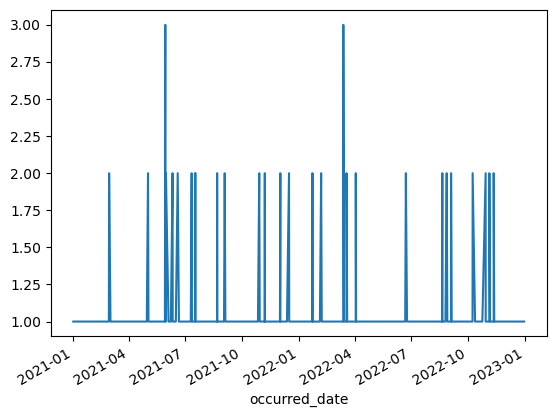

In [31]:
y.plot()

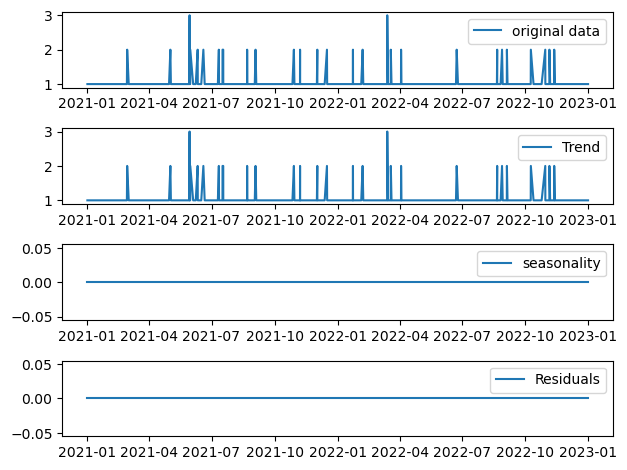

In [32]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition= seasonal_decompose(x=df_assault_21_22_gp['assault_count'], model='additive', extrapolate_trend='freq', period=1)
#decomposition= seasonal_decompose(y)
# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'original data')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### Testing for Stationarity using KPSS<a id='stationarity_test'>
    Kwiatkowski-Phillips-Schmidt-Shin Test

In [33]:
from statsmodels.tsa.stattools import kpss

statistic, p_value, n_lags, critical_values = kpss(df_assault_21_22_gp, nlags='auto')

print('Statistic: ', statistic)
print('p-value: ', p_value)
print('Number of Lags: ', n_lags)
print('Critical Values: ', critical_values)

Statistic:  0.07019219597316702
p-value:  0.1
Number of Lags:  5
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Since our p-value is higher than 0.05, we should  fail to reject the Null hypothesis and deduce the stationarity of our data.



### ADFuller test to test for stationarity<a id='adfuller_test'>

In [35]:
from statsmodels.tsa.stattools import adfuller

In [36]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}\n')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    print() #empty line for formatting
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is STATIONARY")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is NOT STATIONARY")



In [37]:
adf_test(df_assault_21_22_gp)

Augmented Dickey-Fuller Test: 

ADF test statistic     -8.088555e+00
p-value                 1.398273e-12
# lags used             7.000000e+00
# observations          6.800000e+02
critical value (1%)    -3.440003e+00
critical value (5%)    -2.865800e+00
critical value (10%)   -2.569038e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is STATIONARY


### Train_test split<a id='train_test_split'>
Creating train and test file for modeling. <br />


In [52]:
df_assault_21_22_gp.reset_index(inplace=True)

In [53]:
df_assault_21_22_gp.shape

(688, 2)

In [54]:
df_train=df_assault_21_22_gp[df_assault_21_22_gp.occurred_date.between('2021-01-01 00:00:00', '2022-08-31 23:00:00')]

In [55]:
df_test=df_assault_21_22_gp[df_assault_21_22_gp.occurred_date.between('2022-09-01 00:00:00', '2022-12-31 23:00:00')]

In [56]:
df_train.shape

(578, 2)

In [57]:
df_test.shape

(110, 2)

In [ ]:
df_train.set_index('occurred_date',inplace=True)

In [68]:
df_test.set_index('occurred_date',inplace=True)

In [66]:
X_train = df_train

In [69]:
X_test=df_test

In [70]:
X_train.shape, X_test.shape

((578, 1), (110, 1))

In [71]:
y_train, y_test = np.array(range(X_train.shape[0])), np.array(range(X_train.shape[0], df_assault_21_22_gp.shape[0]))

In [72]:
y_train.shape,y_test.shape

((578,), (110,))

Text(0.5, 1.0, 'Assault with crime train and test sets')

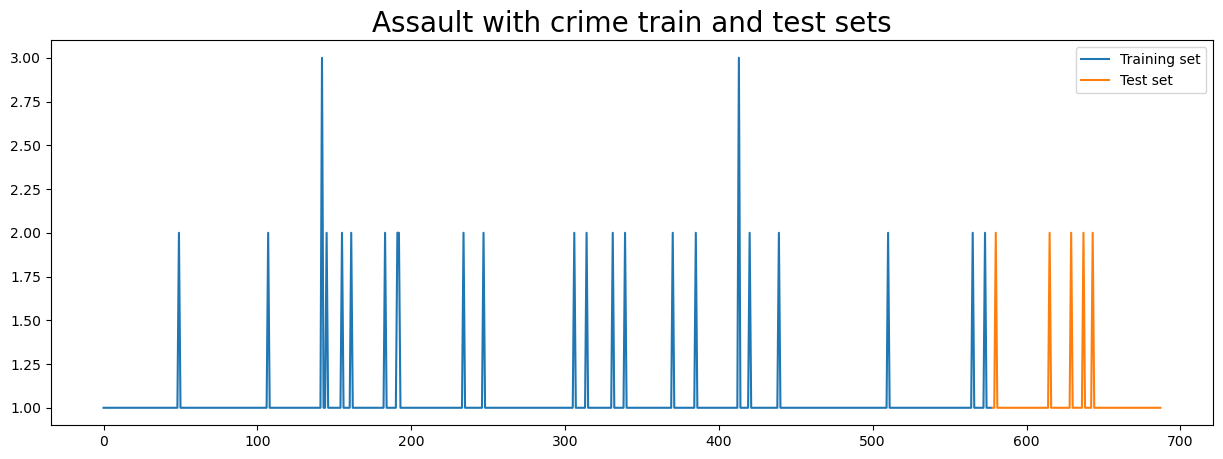

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(y_train, X_train, label='Training set')
ax.plot(y_test, X_test, label='Test set')
plt.legend()
plt.title('Assault with crime train and test sets', size=20)

### Simple Forecast Methods<a id='simple_forecast_methods'>
    
Based on Rob J Hyndman and George Athanasopoulos"<br />
Forecasting: Principles and Practice; 3rd Edition<br />
https://otexts.com/fpp3/

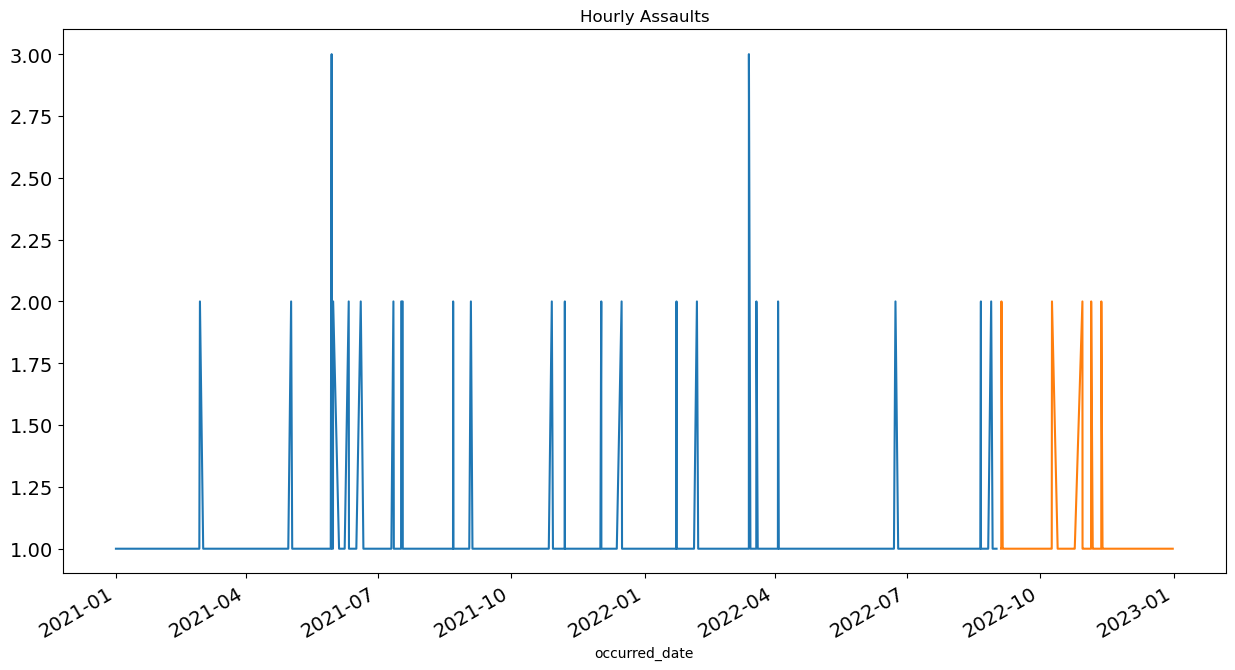

In [175]:
#Plotting data
X_train.assault_count.plot(figsize=(15,8), title='Hourly Assaults', fontsize=14)
X_test.assault_count.plot(figsize=(15,8), title='Hourly Assaults', fontsize=14)
plt.show()

In [279]:
X_train.index

DatetimeIndex(['2021-01-01 04:00:00', '2021-01-01 23:00:00',
               '2021-01-05 23:00:00', '2021-01-06 05:00:00',
               '2021-01-08 00:00:00', '2021-01-08 21:00:00',
               '2021-01-09 01:00:00', '2021-01-09 09:00:00',
               '2021-01-09 18:00:00', '2021-01-10 12:00:00',
               ...
               '2022-08-24 00:00:00', '2022-08-24 07:00:00',
               '2022-08-24 08:00:00', '2022-08-24 17:00:00',
               '2022-08-26 01:00:00', '2022-08-28 02:00:00',
               '2022-08-29 02:00:00', '2022-08-31 01:00:00',
               '2022-08-31 13:00:00', '2022-08-31 19:00:00'],
              dtype='datetime64[ns]', name='occurred_date', length=578, freq=None)

### NAIVE Method<a id='naive_method'>

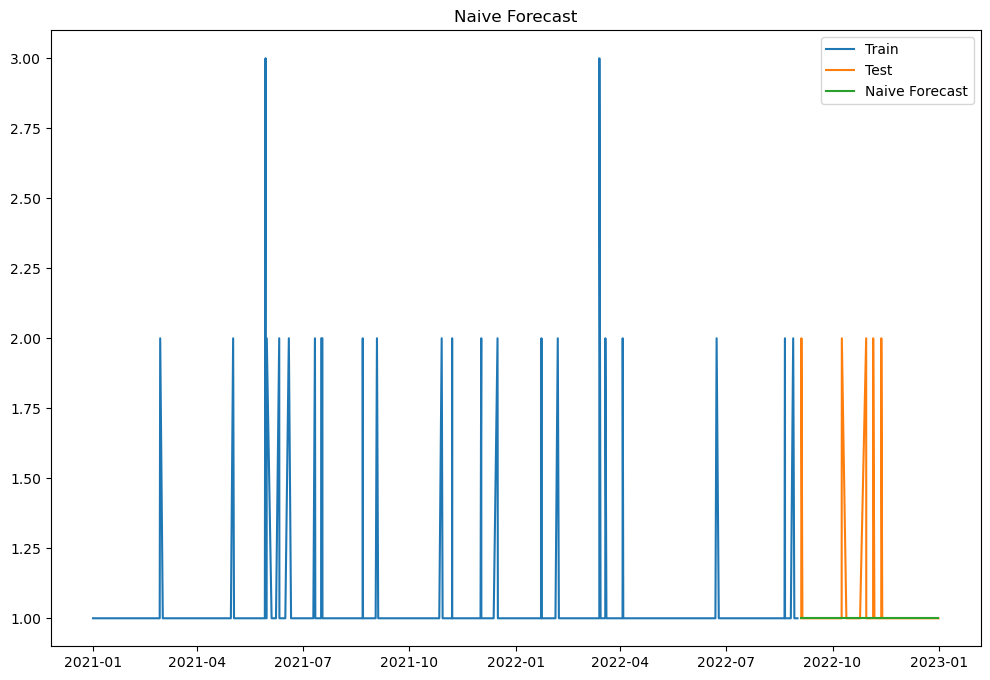

In [183]:
dd= np.asarray(X_train.assault_count)
y_hat = X_test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(X_train.index, X_train['assault_count'], label='Train')
plt.plot(X_test.index,X_test['assault_count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [184]:
rmse = sqrt(mean_squared_error(X_test.assault_count, y_hat.naive))
print("Root Mean Square Error based on Naive method: ",rmse)

Root Mean Square Error based on Naive method:  0.21320071635561044


### Simple Average Method<a id='avg_method'>

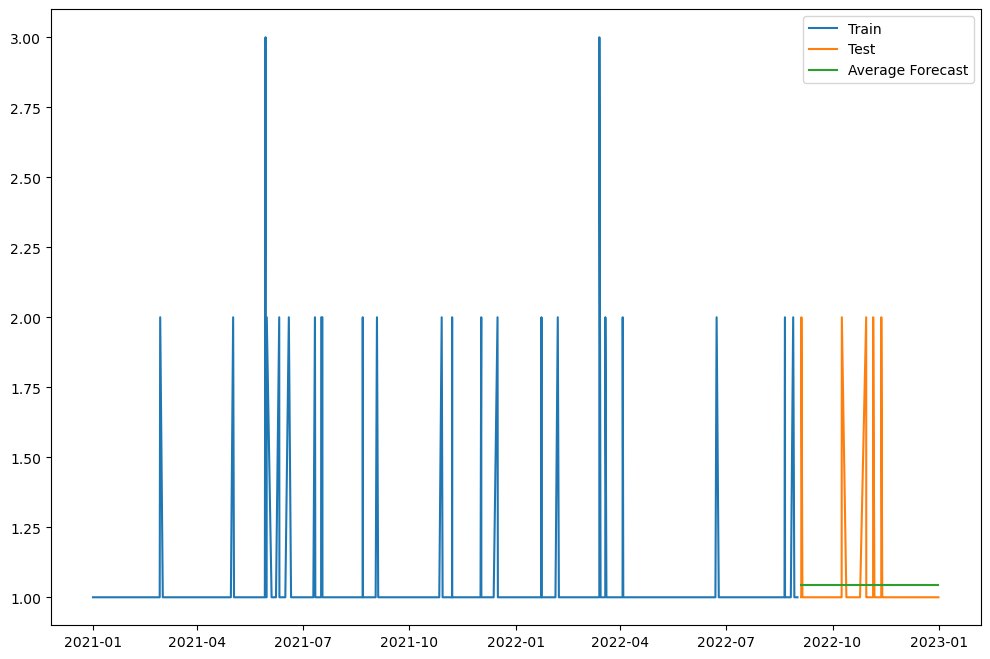

In [178]:
y_hat_avg = X_test.copy()
y_hat_avg['avg_forecast'] = X_train['assault_count'].mean()
plt.figure(figsize=(12,8))
plt.plot(X_train['assault_count'], label='Train')
plt.plot(X_test['assault_count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [179]:
rmse = sqrt(mean_squared_error(X_test.assault_count, y_hat_avg.avg_forecast))
print("Root Mean Square Error based on Simple Average method: ",rmse)

Root Mean Square Error based on Simple Average method:  0.20831053342830427


### Moving Average Method<a id='moving_avg_method'>

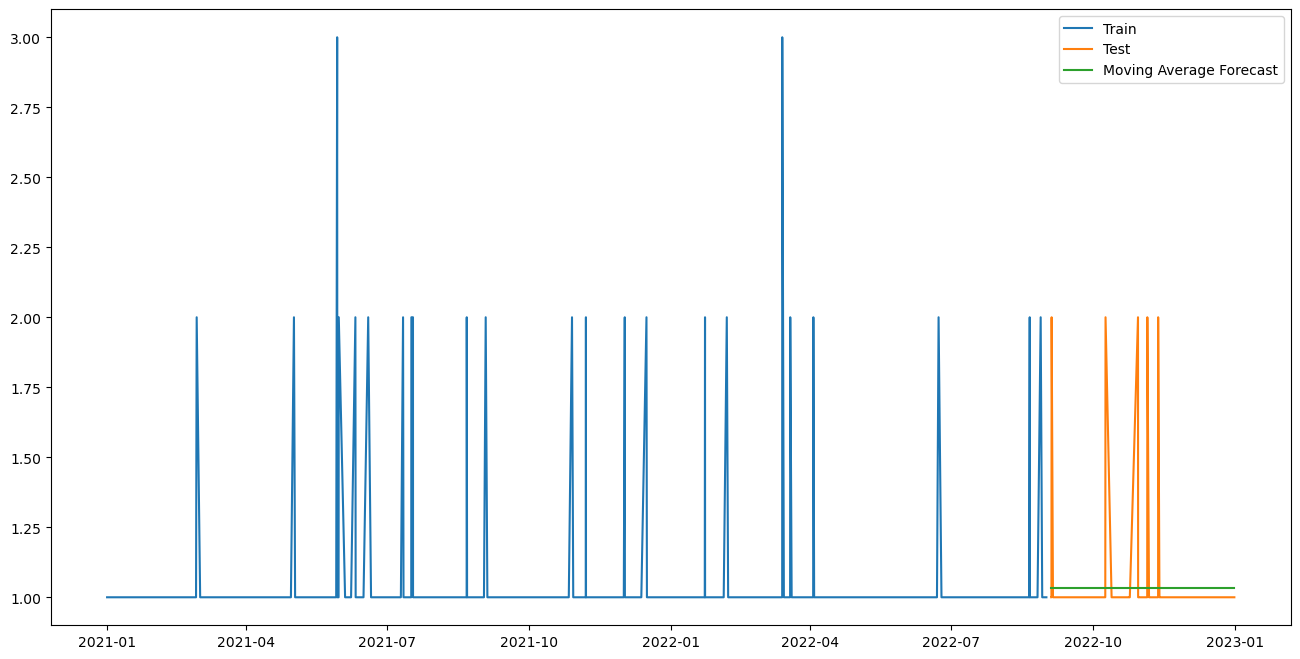

In [283]:
y_hat_avg = X_test.copy()
y_hat_avg['moving_avg_forecast'] = X_train['assault_count'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(X_train['assault_count'], label='Train')
plt.plot(X_test['assault_count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [284]:
rmse = sqrt(mean_squared_error(X_test.assault_count, y_hat_avg.moving_avg_forecast))
print("Root Mean Square Error based on Moving Average method: ",rmse)

Root Mean Square Error based on Moving Average method:  0.208651272546691


### Simple Exponential Smoothing Method<a id='simple_exponential_method'>
<br />Exponential smoothing is a method for forecasting univariate time series data. <br />
It is based on the principle that a prediction is a weighted linear sum of past observations or lags.<br />
The Exponential Smoothing time series method works by assigning exponentially decreasing weights for past observations.

In [121]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

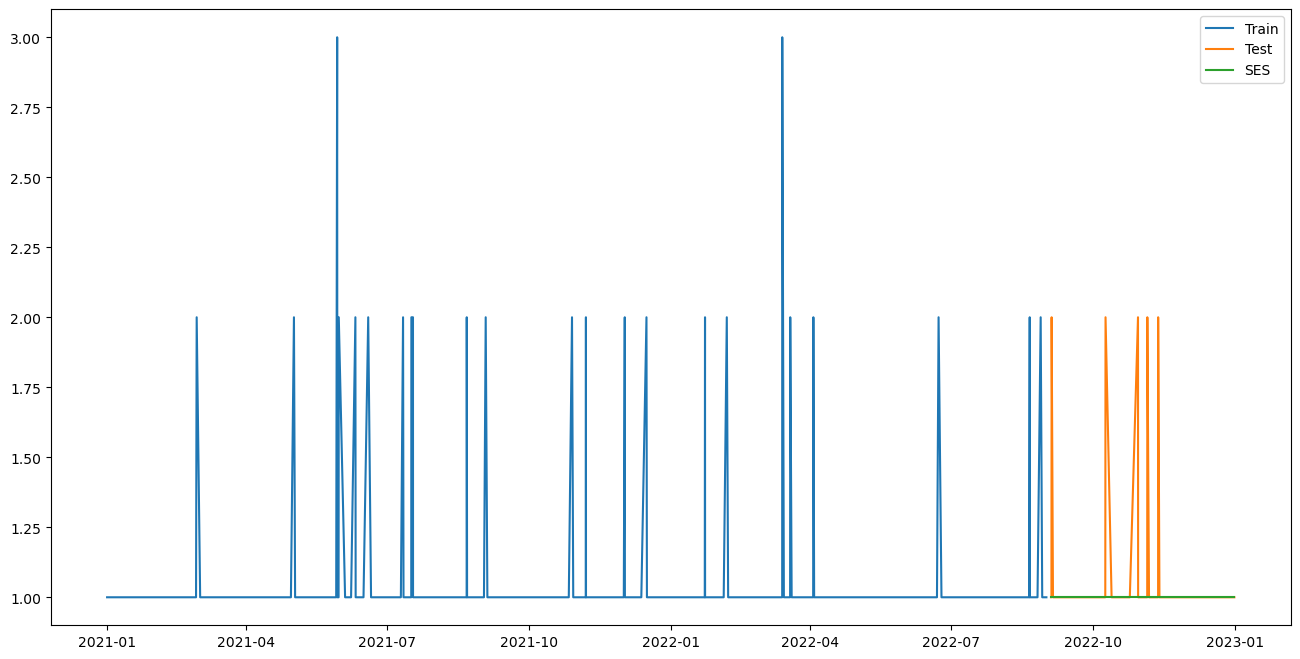

In [248]:
y_hat_avg = X_test.copy()
fit2 = SimpleExpSmoothing(np.asarray(X_train['assault_count'])).fit(smoothing_level=0.8,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(X_test))
plt.figure(figsize=(16,8))
plt.plot(X_train['assault_count'], label='Train')
plt.plot(X_test['assault_count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [188]:
rmse = sqrt(mean_squared_error(X_test.assault_count, y_hat_avg.SES))
print("Root Mean Square Error based on Simple Exponential Smoothing method: ",rmse)

Root Mean Square Error based on Simple Exponential Smoothing method:  0.21293149116248522


##### For Exponential Smoothing, I tried with 0.6 and 0.8 for smoothing_level and observed that 0.8 smoothing_level gave a lower RMSE value and hence will keep 0.8. 

### Autocorrelation and Partial Autocorrelation plots of the data.

Draw a partial autocorrelation graph(ACF) of the data. This will help us in finding the value of p because the cut-off point to the PACF is p. 
Draw an autocorrelation graph(ACF) of the data. This will help us in finding the value of q because the cut-off point to the ACF is q.  

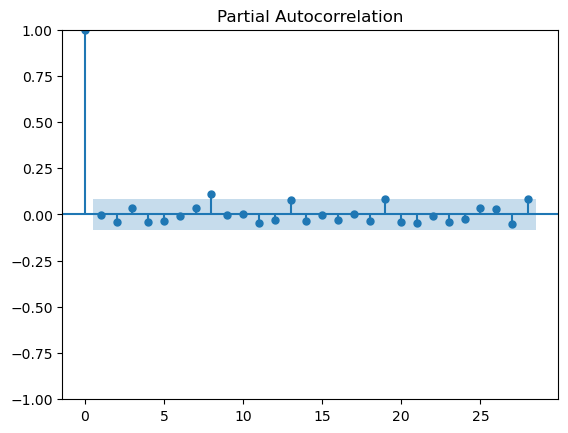

In [128]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(np.array(X_train.assault_count))
plt.show()

### From the above graph, The partial autocorrelation plot (which assists us in determining the AR term) drops  after one lag (we do not count the first lag). This implies that we should use an AR(1) model.

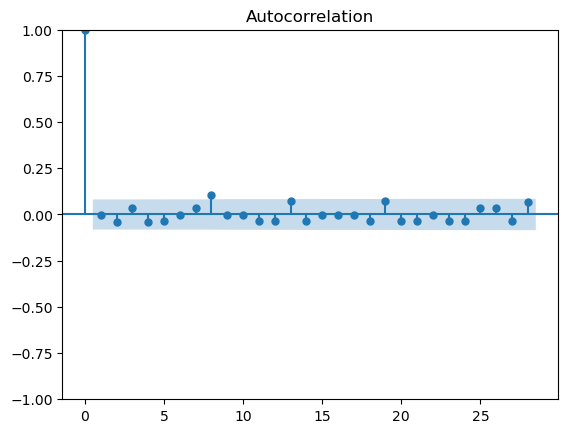

In [129]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.array(X_train.assault_count))
plt.show()

### From the above plot, I will consider MA(1) model

In [132]:
from pmdarima.arima.utils import ndiffs

ndiffs(X_train)

0

#####  order of differencing as per above result. d=0

In [133]:
from pmdarima.arima import nsdiffs
nsdiffs(X_train,12)

0

##### No seasonality as per above result

### Therefore the values of p, d and q, based on the above acf and pacf plots, I am going to consider, p=1, d=0, q=1

In [212]:
model = ARIMA(X_train, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          assault_count   No. Observations:                  578
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  55.875
Date:                Tue, 07 Mar 2023   AIC                           -103.750
Time:                        07:57:41   BIC                            -86.311
Sample:                             0   HQIC                           -96.950
                                - 578                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0433      0.026     39.453      0.000       0.991       1.095
ar.L1         -0.7437      0.711     -1.045      0.296      -2.138       0.651
ma.L1          0.7642      0.675      1.132      0.2

In [227]:
# make predictions using forecast method
predictions_f_ms = model_fit.forecast(steps=len(X_test))
rmse = mean_squared_error(X_test.assault_count, predictions_f_ms)
print("Root Mean Square Error based on ARIMA method(forecast): ",rmse)

Root Mean Square Error based on ARIMA method(forecast):  0.0433242710369246


In [252]:
# make predictions using predict method
predictions_p_ms = model_fit.predict(start=len(X_train), end=len(X_train)+len(X_test)-1)
rmse = mean_squared_error(X_test.assault_count, predictions_p_ms)
print("Root Mean Square Error based on ARIMA method(predict method): ",rmse)

Root Mean Square Error based on ARIMA method(predict method):  0.0433242710369246


In [151]:
import statsmodels.api as sm

In [254]:
len(X_train)

578

In [255]:
len(X_train)+len(X_test)-1

687

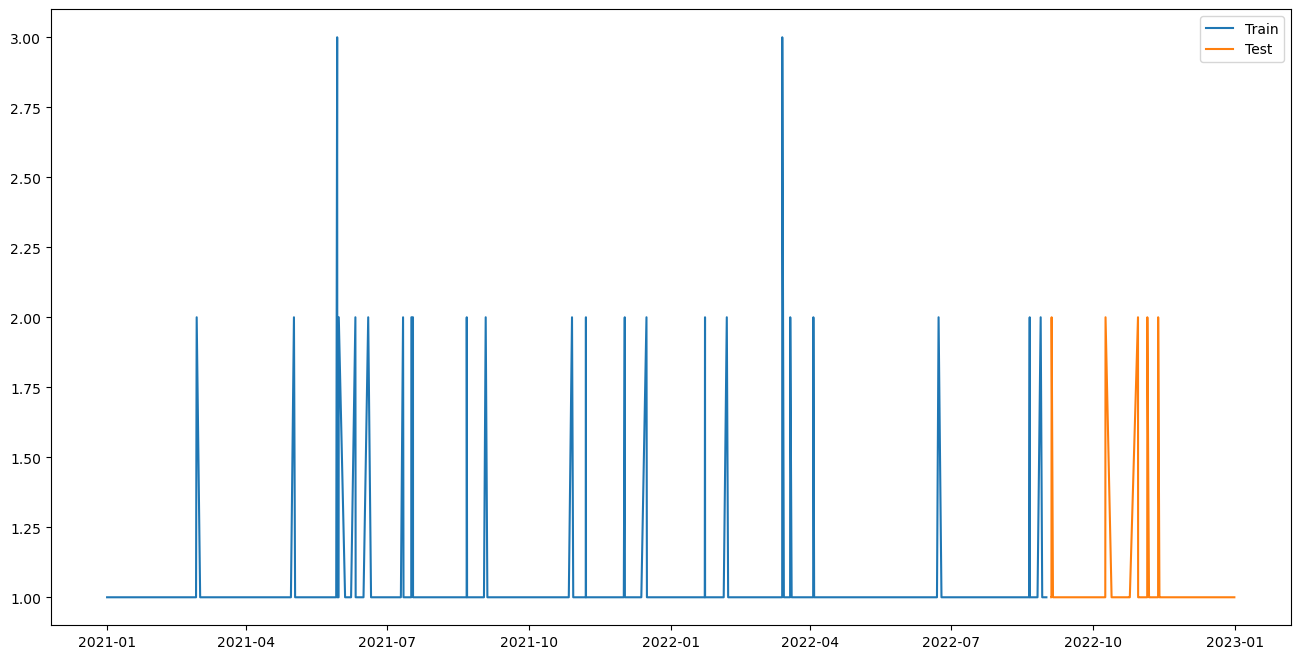

In [267]:
y_hat_avg = X_test.copy()
model= sm.tsa.statespace.SARIMAX(X_train.assault_count, order=(1,0,1),seasonal_order=(1,0,1,12)).fit()
y_hat_avg['SARIMA'] = model.predict(start=578, end=687, dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(X_train['assault_count'], label='Train')
plt.plot(X_test['assault_count'], label='Test')
#plt.plot(y_hat_avg, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [275]:
y_hat_avg

,assault_count,SARIMA
occurred_date,,
2022-09-03 22:00:00,1,NaN
2022-09-04 01:00:00,1,NaN
2022-09-04 04:00:00,2,NaN
2022-09-05 01:00:00,1,NaN
2022-09-05 02:00:00,1,NaN
...,...,...
2022-12-26 12:00:00,1,NaN
2022-12-27 22:00:00,1,NaN
2022-12-28 23:00:00,1,NaN


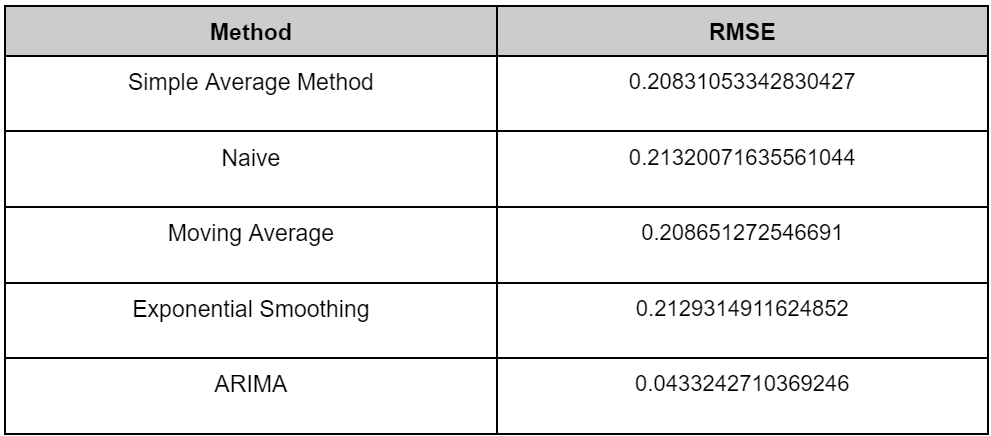

In [286]:
from IPython.display import Image
Image(filename='rmse.png') 